In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## map to string

In [2]:
disgenet_df = pd.read_csv('/itf-fi-ml/shared/users/ziyuzh/svm/data/filtered_icd_list_withoutpub_ids.csv',sep= ';')
omim_df = pd.read_csv('/itf-fi-ml/shared/users/ziyuzh/svm/data/omim/icd10_mapped/omim_details.csv')

In [3]:
disgenet_df.columns,omim_df.columns

(Index(['disease_id', 'omim', 'hpo', 'disease_name', 'gene_id', 'score',
        'first_pub_year', 'last_pub_year', 'ei', 'dsi', 'dpi'],
       dtype='object'),
 Index(['Unnamed: 0', 'omim_disease_name', 'gene', 'icd'], dtype='object'))

In [4]:
import requests

def gene_to_uniprot_human(gene_name):
    url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        "query": f'organism_name:"Homo sapiens" AND gene_exact:{gene_name} AND reviewed:true', 
        "fields": "accession",
        "format": "json"
    }
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        if "results" in data and len(data["results"]) > 0:
            return [entry["primaryAccession"] for entry in data["results"]]  # UniProt Accession IDs
    return None

omim_df['uniprot_id'] = omim_df['gene'].apply(
    lambda x: gene_to_uniprot_human(x)[0] if gene_to_uniprot_human(x) else None
)

uniport_dict = dict()
for gene in disgenet_df['gene_id'].unique().tolist():
    uniport_dict[gene] = gene_to_uniprot_human(gene)[0] if gene_to_uniprot_human(gene) else None
disgenet_df['uniprot_id'] = disgenet_df['gene_id'].map(uniport_dict)

KeyboardInterrupt: 

In [ ]:
local_stringdb = os.path.join('data/stringdb','2023')

ppidf = pd.read_csv(os.path.join(local_stringdb,'9606.protein.info.v12.0.txt'), sep='\t', header=0, usecols=['#string_protein_id', 'preferred_name'])
ppidf['preferred_name'] = ppidf['preferred_name'].str.upper()
stringId2name = ppidf.set_index('#string_protein_id')['preferred_name'].to_dict()
name2stringId = ppidf.set_index('preferred_name')['#string_protein_id'].to_dict()
ppidf = pd.read_csv(os.path.join(local_stringdb,'9606.protein.aliases.v12.0.txt'), sep='\t', header=0, usecols=['#string_protein_id', 'alias']).drop_duplicates(['alias'], keep='first')
ppidf['alias'] = ppidf['alias'].str.upper()
aliases2stringId = ppidf.set_index('alias')['#string_protein_id'].to_dict()

In [49]:
def string_convert(gene):
    if gene in name2stringId.keys():
        return name2stringId[gene]
    elif gene in aliases2stringId.keys():
        return aliases2stringId[gene]
    else:
        return None
    
string_dict = dict()
for gene in disgenet_df['gene_id'].unique().tolist():
    string_dict[gene] = string_convert(gene)
disgenet_df['string_id'] = disgenet_df['gene_id'].map(string_dict)

string_dict = dict()
for gene in omim_df['gene'].unique().tolist():
    string_dict[gene] = string_convert(gene)
omim_df['string_id'] = omim_df['gene'].map(string_dict)

In [51]:
len(disgenet_df[disgenet_df['string_id'].isna()]),len(disgenet_df[disgenet_df['uniprot_id'].isna()])

(512, 414)

In [52]:
len(omim_df[omim_df['string_id'].isna()]),len(omim_df[omim_df['uniprot_id'].isna()])

(189, 207)

In [53]:
disgenet_df_string = disgenet_df.dropna(subset='string_id')
omim_df_string = omim_df.dropna(subset='string_id')

In [56]:
omim_df_string.to_csv('/itf-fi-ml/shared/users/ziyuzh/svm/data/omim/icd10_mapped/omim_string.csv',index=False)
disgenet_df_string.to_csv('/itf-fi-ml/shared/users/ziyuzh/svm/data/disgent_2020/disgenet_string.csv',index=False)

In [6]:
omim_df_string = pd.read_csv('/itf-fi-ml/shared/users/ziyuzh/svm/data/omim/icd10_mapped/omim_string.csv')
disgenet_df_string = pd.read_csv('/itf-fi-ml/shared/users/ziyuzh/svm/data/disgent_2020/disgenet_string.csv')

In [7]:
for icd in omim_df_string['icd'].unique().tolist():
    omom_sub = omim_df_string[omim_df_string['icd']==icd]
    dis_sub = disgenet_df_string[disgenet_df_string['disease_id']==icd]
    print(icd,len(omom_sub),len(dis_sub),len(set(omom_sub['string_id'].tolist())&set(dis_sub['string_id'].tolist())))

ICD10_C16 12 95 12
ICD10_C18 34 50 9
ICD10_C43 10 52 4
ICD10_C45 2 43 2
ICD10_C50 24 716 22
ICD10_C56 11 124 10
ICD10_C61 18 565 11
ICD10_C67 4 199 4
ICD10_D57 1 22 1
ICD10_D81 9 20 1
ICD10_D83 13 27 12
ICD10_E10 1 113 1
ICD10_E11 6 288 6
ICD10_E66 29 284 22
ICD10_E84 4 48 3
ICD10_F01 1 41 1
ICD10_G10 3 38 3
ICD10_G20 23 146 17
ICD10_G24 31 30 14
ICD10_G30 11 198 11
ICD10_G35 5 119 4
ICD10_G40 71 136 15
ICD10_G91 2 25 0
ICD10_H40 11 24 4
ICD10_I10 7 37 6
ICD10_I25 2 166 1
ICD10_I42 51 171 38
ICD10_I50 1 160 1
ICD10_I63 2 49 2
ICD10_I70 1 69 1
ICD10_I95 2 55 0
ICD10_J45 16 205 15
ICD10_K44 1 64 1
ICD10_K51 12 75 5
ICD10_L23 2 71 0
ICD10_L40 7 79 6
ICD10_L80 1 39 1
ICD10_M32 12 113 11
ICD10_M41 8 41 1
ICD10_M45 1 26 1
ICD10_N04 25 80 11
ICD10_D46 7 17 5
ICD10_M16 7 18 0
ICD10_A30 4 13 3
ICD10_B50 17 12 3
ICD10_C91 8 14 0
ICD10_E85 10 11 3
ICD10_G21 6 14 1
ICD10_I60 1 14 0
ICD10_J47 4 10 2
ICD10_M10 10 15 2
ICD10_M88 4 13 4


In [8]:
disease = 'ICD10_C18'
omim_df_string[omim_df_string['icd']==disease]

,Unnamed: 0,omim_disease_name,gene,icd,uniprot_id,string_id
12,12,COLORECTAL CANCER,CTNNB1,ICD10_C18,P35222,9606.ENSP00000495360
13,13,COLORECTAL CANCER,MLH1,ICD10_C18,P40692,9606.ENSP00000231790
14,14,COLORECTAL CANCER,DCC,ICD10_C18,P43146,9606.ENSP00000389140
15,15,COLORECTAL CANCER,FGFR3,ICD10_C18,P22607,9606.ENSP00000339824
16,16,COLORECTAL CANCER,MCC,ICD10_C18,P23508,9606.ENSP00000386227
17,17,COLORECTAL CANCER,AKT1,ICD10_C18,P31749,9606.ENSP00000451828
18,18,COLORECTAL CANCER,BRAF,ICD10_C18,P15056,9606.ENSP00000419060
19,19,COLORECTAL CANCER,NRAS,ICD10_C18,P01111,9606.ENSP00000358548
20,20,COLORECTAL CANCER,CCND1,ICD10_C18,P24385,9606.ENSP00000227507
21,21,COLORECTAL CANCER,PIK3CA,ICD10_C18,P42336,9606.ENSP00000263967


In [9]:
disgenet_df_string[disgenet_df_string['disease_id']==disease]

,disease_id,omim,hpo,disease_name,gene_id,score,first_pub_year,last_pub_year,ei,dsi,dpi,uniprot_id,string_id
219,ICD10_C18,OMIM_191170,HPO_HP:0003003,Malignant neoplasm of colon,APC,0.95,2020.0,2020.0,0.907,0.364,0.913,P25054,9606.ENSP00000257430
220,ICD10_C18,OMIM_191170,HPO_HP:0003003,Malignant neoplasm of colon,AKT1,0.90,NaN,NaN,0.995,0.283,0.957,P31749,9606.ENSP00000451828
221,ICD10_C18,OMIM_191170,HPO_HP:0003003,Malignant neoplasm of colon,MLH1,0.90,1998.0,2020.0,0.928,0.382,0.913,P40692,9606.ENSP00000231790
222,ICD10_C18,OMIM_191170,HPO_HP:0003003,Malignant neoplasm of colon,BRAF,0.85,NaN,NaN,0.912,0.290,0.957,P15056,9606.ENSP00000419060
223,ICD10_C18,OMIM_191170,HPO_HP:0003003,Malignant neoplasm of colon,PPARG,0.85,NaN,NaN,0.928,0.334,0.957,P37231,9606.ENSP00000287820
224,ICD10_C18,OMIM_191170,HPO_HP:0003003,Malignant neoplasm of colon,MSH2,0.85,2020.0,2020.0,0.947,0.390,0.957,P43246,9606.ENSP00000233146
225,ICD10_C18,OMIM_191170,HPO_HP:0003003,Malignant neoplasm of colon,TGFBR2,0.85,NaN,NaN,0.957,0.368,0.957,P37173,9606.ENSP00000351905
226,ICD10_C18,OMIM_191170,HPO_HP:0003003,Malignant neoplasm of colon,MAPK14,0.80,NaN,NaN,0.980,0.379,0.913,Q16539,9606.ENSP00000229795
227,ICD10_C18,OMIM_191170,HPO_HP:0003003,Malignant neoplasm of colon,CASP3,0.80,NaN,NaN,0.912,0.363,0.913,P42574,9606.ENSP00000311032
228,ICD10_C18,OMIM_191170,HPO_HP:0003003,Malignant neoplasm of colon,PMS2,0.80,2020.0,2020.0,0.905,0.461,0.913,P54278,9606.ENSP00000265849


In [68]:
disgenet_df[disgenet_df['disease_id']=='ICD10_C50']

,disease_id,omim,hpo,disease_name,gene_id,score,first_pub_year,last_pub_year,ei,dsi,dpi,uniprot_id,string_id
433,ICD10_C50,OMIM_114480,NaN,"Cancer, Breast",ESR1,1.0,NaN,NaN,0.912,0.297,0.957,P03372,9606.ENSP00000405330
434,ICD10_C50,OMIM_114480,NaN,"Cancer, Breast",BRCA1,1.0,1994.0,2019.0,0.883,0.341,0.957,P38398,9606.ENSP00000418960
435,ICD10_C50,OMIM_114480,NaN,"Cancer, Breast",BRCA2,1.0,1969.0,2022.0,0.889,0.355,0.957,P51587,9606.ENSP00000369497
436,ICD10_C50,OMIM_114480,NaN,"Cancer, Breast",PIK3CA,1.0,2006.0,2006.0,0.949,0.275,0.957,P42336,9606.ENSP00000263967
437,ICD10_C50,OMIM_114480,NaN,"Cancer, Breast",TP53,1.0,2010.0,2019.0,0.898,0.256,0.957,P04637,9606.ENSP00000269305
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,ICD10_C50,OMIM_114480,NaN,"Cancer, Breast",MTMR8,0.4,NaN,NaN,0.000,0.896,0.217,Q96EF0,9606.ENSP00000363985
1165,ICD10_C50,OMIM_114480,NaN,"Cancer, Breast",DHX32,0.4,NaN,NaN,0.000,0.758,0.304,Q7L7V1,9606.ENSP00000284690
1166,ICD10_C50,OMIM_114480,NaN,"Cancer, Breast",NDUFA3,0.4,NaN,NaN,0.000,1.000,0.087,O95167,9606.ENSP00000418438
1167,ICD10_C50,OMIM_114480,NaN,"Cancer, Breast",NIP7,0.4,NaN,NaN,0.000,0.935,0.087,Q9Y221,9606.ENSP00000254940


## time annotations

In [2]:
disgenet_df_string = pd.read_csv('/itf-fi-ml/shared/users/ziyuzh/svm/data/disgent_2020/disgenet_string.csv')
disgenet_df_string.head(3)

,disease_id,omim,hpo,disease_name,gene_id,score,first_pub_year,last_pub_year,ei,dsi,dpi,uniprot_id,string_id
0,ICD10_A23,NaN,NaN,Brucelloses,CXCL8,0.60,NaN,NaN,1.000,0.290,0.957,P10145,9606.ENSP00000306512
1,ICD10_A23,NaN,NaN,Brucelloses,NPC1,0.40,2002.0,2002.0,1.000,0.527,0.913,O15118,9606.ENSP00000269228
2,ICD10_A30,NaN,NaN,Leprosy,SLC11A1,0.85,2006.0,2006.0,0.857,0.469,0.913,P49279,9606.ENSP00000233202


In [3]:
selected_15_df = disgenet_df_string.groupby('disease_id').filter(lambda x: len(x) > 15)
selected_15_df

,disease_id,omim,hpo,disease_name,gene_id,score,first_pub_year,last_pub_year,ei,dsi,dpi,uniprot_id,string_id
124,ICD10_C16,OMIM_613659,HPO_HP:0012126,Malignant neoplasm of stomach,ERBB2,1.0,2004.0,2007.0,0.917,0.298,0.957,P04626,9606.ENSP00000269571
125,ICD10_C16,OMIM_613659,HPO_HP:0012126,Malignant neoplasm of stomach,PIK3CA,1.0,2004.0,2023.0,0.978,0.275,0.957,P42336,9606.ENSP00000263967
126,ICD10_C16,OMIM_613659,HPO_HP:0012126,Malignant neoplasm of stomach,TP53,1.0,2011.0,2023.0,0.911,0.256,0.957,P04637,9606.ENSP00000269305
127,ICD10_C16,OMIM_613659,HPO_HP:0012126,Malignant neoplasm of stomach,FGFR2,1.0,1999.0,2001.0,0.937,0.341,0.913,P21802,9606.ENSP00000410294
128,ICD10_C16,OMIM_613659,HPO_HP:0012126,Malignant neoplasm of stomach,IL1B,1.0,NaN,NaN,0.879,0.265,0.957,P01584,9606.ENSP00000263341
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8220,ICD10_N97,NaN,HPO_HP:0008222,"Infertility, Female",AHR,0.4,2023.0,2023.0,1.000,0.383,0.957,P35869,9606.ENSP00000242057
8221,ICD10_N97,NaN,HPO_HP:0008222,"Infertility, Female",FSHB,0.4,1993.0,1993.0,1.000,0.599,0.696,P01225,9606.ENSP00000416606
8222,ICD10_N97,NaN,HPO_HP:0008222,"Infertility, Female",LEPR,0.4,2012.0,2012.0,1.000,0.413,0.957,P48357,9606.ENSP00000330393
8223,ICD10_N97,NaN,HPO_HP:0008222,"Infertility, Female",RNF212B,0.4,NaN,NaN,0.000,-0.000,0.000,A8MTL3,9606.ENSP00000382794


In [11]:
selected_15_df[selected_15_df['first_pub_year'].isna()]['disease_name'].nunique()

69

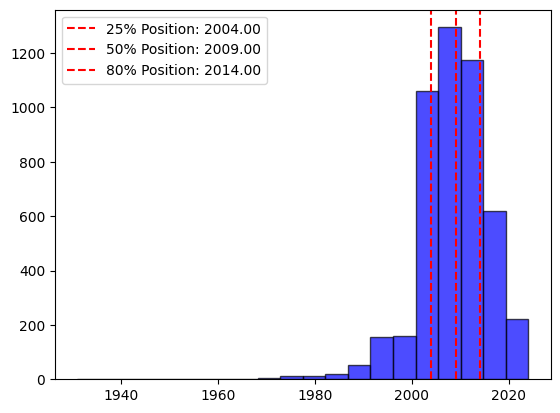

In [20]:

data = selected_15_df[~selected_15_df['first_pub_year'].isna()]['first_pub_year']

# Create the histogram
plt.hist(data, bins=20, alpha=0.7, color='blue', edgecolor='black')

# Calculate the percentiles
percentiles = np.percentile(data, [25, 50, 80])
labels = ['25%', '50%', '80%']

# Add vertical lines for the percentiles
for percentile, label in zip(percentiles, labels):
    plt.axvline(percentile, color='red', linestyle='--', label=f'{label} Position: {percentile:.2f}')

# Add a legend
plt.legend()

In [8]:
len(selected_15_df[~selected_15_df['first_pub_year'].isna()])

4793

In [13]:
import requests

def get_earliest_pubmed_pmid_and_year(gene, disease):
    # Construct the search query
    query = f"{gene} AND {disease}"
    
    # PubMed URL to get the total number of results
    search_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={query}&retmode=json&sort=pub+date"
    
    try:
        # Fetch search results to get the total count
        response = requests.get(search_url)
        response.raise_for_status()
        total_results = int(response.json().get("esearchresult", {}).get("count", 0))

        if total_results == 0:
            print("No results found for the given query.")
            return None, None

        # Fetch only the last result (earliest publication)
        earliest_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={query}&retstart={total_results - 1}&retmax=1&retmode=json&sort=pub+date"
        earliest_response = requests.get(earliest_url)
        earliest_response.raise_for_status()
        pmid = earliest_response.json().get("esearchresult", {}).get("idlist", [])[0]

        # Fetch the publication year for the earliest publication
        summary_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id={pmid}&retmode=json"
        summary_response = requests.get(summary_url)
        summary_response.raise_for_status()
        pub_year = summary_response.json()["result"][pmid]["pubdate"].split()[0]  # Extract the year

        return pmid, pub_year

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None, None

# Example usage
gene = "IFNG"
disease = "Breast Cancer"
result = get_earliest_pubmed_pmid_and_year(gene, disease)

# Print the earliest publication PMID and year
if result:
    pmid, pub_year = result
    print(f"PMID: {pmid}\nPublication Year: {pub_year}")

PMID: 11076645
Publication Year: 2000


In [18]:
non_time_df = selected_15_df[selected_15_df['first_pub_year'].isna()]
non_time_df['ori_annotation'] = False


/tmp/ipykernel_3907851/1113968641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_time_df['ori_annotation'] = False


In [19]:
# Define a function that will work with a row
def fetch_pubmed_data(row):
    pmid, pub_year = get_earliest_pubmed_pmid_and_year(row['gene_id'], row['disease_name'])
    return pd.Series([pmid, pub_year])

# Apply the function to each row
non_time_df[['pmid', 'first_pub_year']] = non_time_df.apply(fetch_pubmed_data, axis=1)

No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results found for the given query.
No results f

/tmp/ipykernel_3907851/4005304590.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_time_df[['pmid', 'first_pub_year']] = non_time_df.apply(fetch_pubmed_data, axis=1)


In [41]:
non_time_df[non_time_df['first_pub_year'].isna()].to_csv('/itf-fi-ml/shared/users/ziyuzh/svm/data/disgent_2020/timecut/non_pub_annotations_df.csv',index=False)

In [37]:
non_time_df = non_time_df[~non_time_df['first_pub_year'].isna()]
len(non_time_df)

2357

In [38]:
def process_year(year):
    if isinstance(year, str) and '-' in year:
        # If it's a string containing a hyphen, split and take the first part
        return year.split('-')[0]
    return year  # Return as is if it's not a string with a hyphen

# Apply the function to the first_pub_year column
non_time_df['first_pub_year'] = non_time_df['first_pub_year'].apply(process_year)


/tmp/ipykernel_3907851/1426023832.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_time_df['first_pub_year'] = non_time_df['first_pub_year'].apply(process_year)


(array([  1.,   0.,   0.,   5.,   6.,  45., 148., 775., 973., 404.]),
 array([1909. , 1920.6, 1932.2, 1943.8, 1955.4, 1967. , 1978.6, 1990.2,
        2001.8, 2013.4, 2025. ]),
 <BarContainer object of 10 artists>)

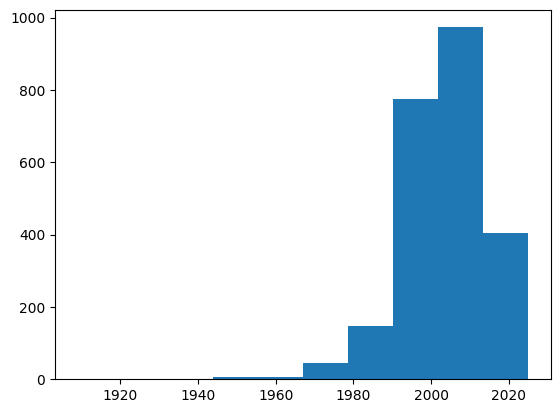

In [40]:
plt.hist(non_time_df['first_pub_year'].astype(int))

In [43]:
time_df = selected_15_df[~selected_15_df['first_pub_year'].isna()]
time_df['ori_annotation'] = True

non_time_df['first_pub_year'] = non_time_df['first_pub_year'].astype(int)

/tmp/ipykernel_3907851/713477960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df['ori_annotation'] = True
/tmp/ipykernel_3907851/713477960.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_time_df['first_pub_year'] = non_time_df['first_pub_year'].astype(int)


In [45]:
combined_df = pd.concat([time_df, non_time_df[time_df.columns]], ignore_index=True)

In [49]:
len(combined_df)

7150

In [47]:
combined_df.to_csv('/itf-fi-ml/shared/users/ziyuzh/svm/data/disgent_2020/timecut/disgent_with_time.csv',index=False)

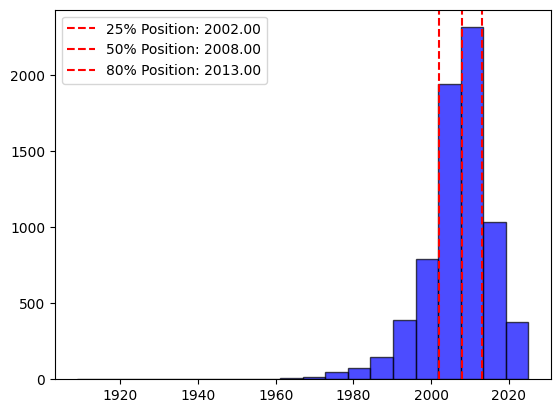

In [48]:

data = combined_df['first_pub_year']

# Create the histogram
plt.hist(data, bins=20, alpha=0.7, color='blue', edgecolor='black')

# Calculate the percentiles
percentiles = np.percentile(data, [25, 50, 80])
labels = ['25%', '50%', '80%']

# Add vertical lines for the percentiles
for percentile, label in zip(percentiles, labels):
    plt.axvline(percentile, color='red', linestyle='--', label=f'{label} Position: {percentile:.2f}')

# Add a legend
plt.legend()